# Módulos

In [3]:
# Biblioteca básica do python
import numpy as np
import pandas as pd
# Para etapa de pré-processamento
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# Para o desenvolvimento dos modelos de Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
# Para fazer alguns gráficos caso necessário
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Definir semente para reprodutibilidade
np.random.seed(1206)

# Parte 1: Pré-processamento dos dados

In [5]:
# Importando banco de dados
data_apple = pd.read_csv('./dados/apple_prices.csv', names=['preco'], header=None)
data_leite = pd.read_csv('./dados/monthly-milk-production-pounds.csv')

# Corrigindo alguns detalhes dos bancos de dados
data_leite = data_leite[0:168]
data_leite.columns = ['mes', 'producao']

In [6]:
# Tornando as colunas em arrays de dimensão (N,1)
producao = data_leite['producao'].values.reshape((-1,1))
preco = data_apple['preco'].values.reshape((-1,1))

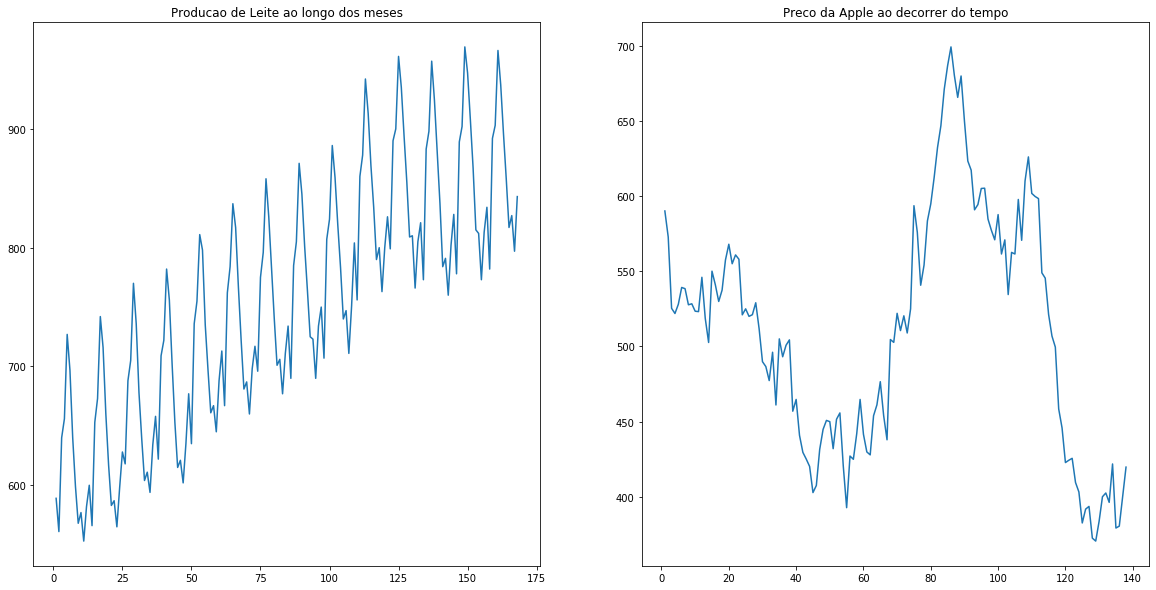

In [7]:
# Fazer os gráficos de ambas as séries
## Declarar eixos e a figura
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
## Plot producao de leite
ax1.set_title('Producao de Leite ao longo dos meses')
ax1.plot(list(range(1,len(producao)+1)),list(producao.reshape(-1)));
## Plot preços da Apple
ax2.set_title('Preco da Apple ao decorrer do tempo')
ax2.plot(list(range(1,len(preco)+1)),list(preco.reshape(-1)));

Explicar objetivo de ambas as predições, prever os 20% finais da série

## Hold-out Split

In [8]:
# Porcentagem de divisão dos dados
split = 0.80

# Divisão para produção de leite
pSplit = int(split*len(producao))
producao_train = producao[:pSplit] 
producao_test = producao[pSplit:]

# Divisão para preços da Apple
aSplit = int(split*len(preco))
preco_train = preco[:aSplit]
preco_test = preco[aSplit:]

# Print
print('Producão -> Train: ',len(producao_train),' Test: ',len(producao_test))
print('Preço    -> Train: ',len(preco_train),' Test: ',len(preco_test))

Producão -> Train:  134  Test:  34
Preço    -> Train:  110  Test:  28


## Standardization

Normalizacao explicada aqui

In [9]:
# Producao de Leite
## Declare o objeto para o processo de padronizacao
sspl = StandardScaler()

## Calcule os parâmetros (fit) e transforme o conjunto X (transform)  
producao_train = sspl.fit_transform(X = producao_train)

## Transforme o conjunto de test baseado nos parâmetros de train
producao_test = sspl.transform(X = producao_test)

In [10]:
# Preco da Apple
## Declare o objeto para processo de padronizacao
sspa = StandardScaler()

## Calcule os parâmetros (fit) e transforme o conjunto X (transform)  
preco_train = sspa.fit_transform(X = preco_train)

## Transforme o conjunto de test baseado nos parâmetros de train
preco_test = sspa.transform(X = preco_test)

## Criando as janelas temporais


explicar o que é batch e a relacao com epochs

In [11]:
# Tamanho da janela temporal utilizada para prever o valor futuro
window_size = 3

# Tamanho do batch
n_batchs = 3

In [12]:
# Criação das séries para producao
producao_train_sequence = TimeseriesGenerator(data=producao_train,
                                              targets=producao_train,
                                              length=window_size,
                                              batch_size=n_batchs)
producao_test_sequence = TimeseriesGenerator(data=producao_test,
                                              targets=producao_test,
                                              length=window_size,
                                              batch_size=1)

In [13]:
# Criação das séries para preço
preco_train_sequence = TimeseriesGenerator(data=preco_train,
                                              targets=preco_train,
                                              length=window_size,
                                              batch_size=n_batchs)
preco_test_sequence = TimeseriesGenerator(data=preco_test,
                                              targets=preco_test,
                                              length=window_size,
                                              batch_size=1)

falar do nrow-window size!!! (34-3 = 31)

Explicar o que são batchs (quantidade de dados (pacotes) usados em uma interação)

Visualizar

In [14]:
#for i in range(len(producao_test_sequence)-20):
#    x, y = producao_test_sequence[i]
#    print('Train:\n%s\n\nFuture:\n%s\n' % (x, y))    

In [15]:
len(producao_test_sequence)

31

# Parte 2: Explicando alguns conceitos teóricos importantes
batch
epochs
dropout
batch_normalization
falar que tentou aplicar outras tecnicas de regularizacao mas que nao funfou

# Parte 3: Criando a Rede Recorrente LSTM para produção de Leite

In [16]:
# Criando objeto do modelo
lstm_model = Sequential(name='LSTM_MODEL')

In [17]:
# Adicionar primeira camada
lstm_model.add(LSTM(units=100,activation='relu', input_shape=(window_size, 1), return_sequences=True))
# Adicionar segunda camada
lstm_model.add(LSTM(units=100,activation='relu'))
# Adicionar camada de saida
lstm_model.add(Dense(units=1))

# Descrição do modelo
lstm_model.summary()

Model: "LSTM_MODEL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 100)            40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compilar o modelo
lstm_model.compile(optimzer='adam', loss='mse', metrics=['mse'])

In [19]:
# Treinando o modelo
LSTM_history = lstm_model.fit_generator(producao_train_sequence, epochs=15, verbose=2);

Epoch 1/15
44/44 - 2s - loss: 0.7599 - mse: 0.7616
Epoch 2/15
44/44 - 1s - loss: 0.5214 - mse: 0.5245
Epoch 3/15
44/44 - 1s - loss: 0.4635 - mse: 0.4649
Epoch 4/15
44/44 - 1s - loss: 0.4118 - mse: 0.4136
Epoch 5/15
44/44 - 1s - loss: 0.3622 - mse: 0.3642
Epoch 6/15
44/44 - 1s - loss: 0.3577 - mse: 0.3595
Epoch 7/15
44/44 - 1s - loss: 0.3137 - mse: 0.3146
Epoch 8/15
44/44 - 1s - loss: 0.2744 - mse: 0.2752
Epoch 9/15
44/44 - 1s - loss: 0.2710 - mse: 0.2723
Epoch 10/15
44/44 - 1s - loss: 0.2682 - mse: 0.2694
Epoch 11/15
44/44 - 1s - loss: 0.2325 - mse: 0.2333
Epoch 12/15
44/44 - 1s - loss: 0.2500 - mse: 0.2511
Epoch 13/15
44/44 - 1s - loss: 0.2550 - mse: 0.2561
Epoch 14/15
44/44 - 1s - loss: 0.2391 - mse: 0.2401
Epoch 15/15
44/44 - 1s - loss: 0.2273 - mse: 0.2279


# Parte 4: Criando a Rede Recorrente GRU para produção de Leite

In [20]:
# Criando objeto do modelo
gru_model = Sequential(name='GRU_MODEL')

In [21]:
# Adicionar primeira camada
gru_model.add(GRU(units=100, activation='relu', input_shape=(window_size, 1), return_sequences=True))
# Adicionar segunda camada
gru_model.add(GRU(units=100, activation='relu'))
# Adicionar camada de saida
gru_model.add(Dense(units=1))

# Descrição do modelo
gru_model.summary()

Model: "GRU_MODEL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 3, 100)            30900     
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 91,601
Trainable params: 91,601
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Compilar o modelo
gru_model.compile(optimzer='adam', loss='mse', metrics=['mse'])

In [23]:
# Treinando o modelo
GRU_history = gru_model.fit_generator(producao_train_sequence, epochs=15, verbose=2);

Epoch 1/15
44/44 - 2s - loss: 0.7055 - mse: 0.7079
Epoch 2/15
44/44 - 2s - loss: 0.4222 - mse: 0.4246
Epoch 3/15
44/44 - 2s - loss: 0.3480 - mse: 0.3497
Epoch 4/15
44/44 - 2s - loss: 0.2929 - mse: 0.2942
Epoch 5/15
44/44 - 2s - loss: 0.2430 - mse: 0.2440
Epoch 6/15
44/44 - 2s - loss: 0.2415 - mse: 0.2421
Epoch 7/15
44/44 - 2s - loss: 0.2154 - mse: 0.2160
Epoch 8/15
44/44 - 2s - loss: 0.2345 - mse: 0.2344
Epoch 9/15
44/44 - 2s - loss: 0.2133 - mse: 0.2139
Epoch 10/15
44/44 - 2s - loss: 0.2033 - mse: 0.2027
Epoch 11/15
44/44 - 2s - loss: 0.2354 - mse: 0.2360
Epoch 12/15
44/44 - 2s - loss: 0.2182 - mse: 0.2189
Epoch 13/15
44/44 - 2s - loss: 0.2046 - mse: 0.2050
Epoch 14/15
44/44 - 2s - loss: 0.1999 - mse: 0.1996
Epoch 15/15
44/44 - 2s - loss: 0.2245 - mse: 0.2252


# Parte 5: Comparando os resultados

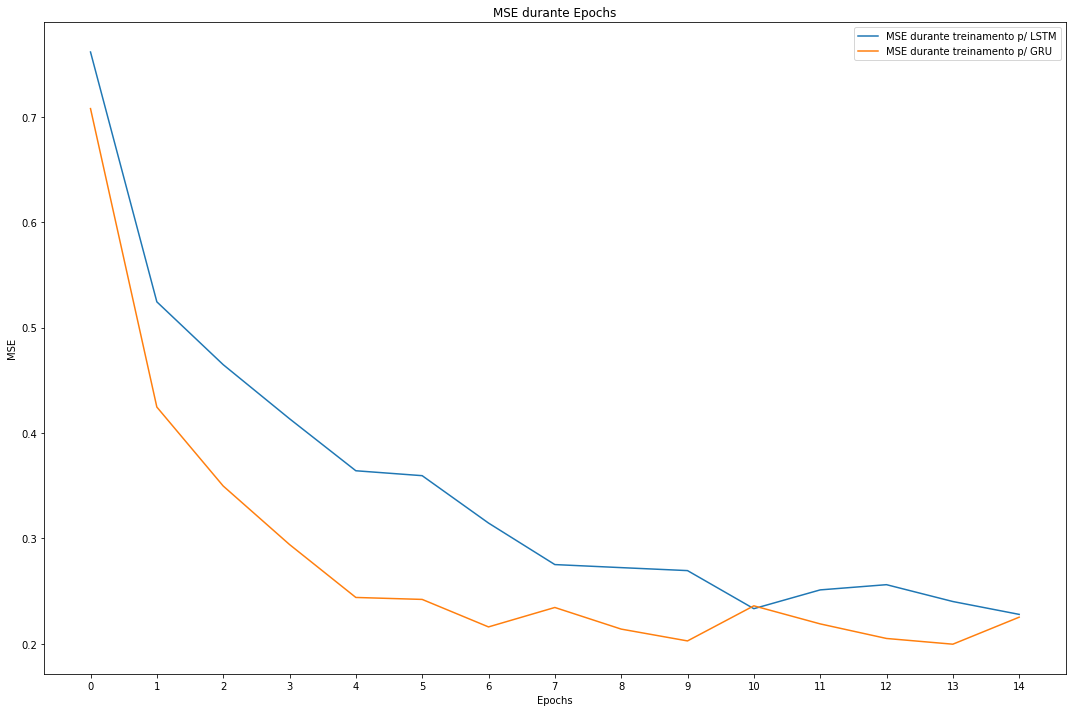

In [24]:
# Plot do treinamento
epochs_range = list(range(0,15))
# Plots
plt.figure(figsize=(15,10));
# Accuracy X Epochs
plt.plot(LSTM_history.history['mse'], label='MSE durante treinamento p/ LSTM')
plt.plot(GRU_history.history['mse'], label='MSE durante treinamento p/ GRU')
plt.title('MSE durante Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.xticks(epochs_range)
plt.legend(loc='upper right')

# Default to improve spaces between the plots
plt.tight_layout()

In [25]:
# Prever valores futuros(validação) com LSTM
LSTM_pred = lstm_model.predict_generator(generator=producao_test_sequence)
# Prever valores futuros(validação) com GRU
GRU_pred = gru_model.predict_generator(generator=producao_test_sequence)

In [31]:
# Criando o eixo X para fazer os plots de predição
xtrain = range(0, len(producao_train) + window_size)
xpreds = range(len(producao_train) + window_size, len(producao_train) + len(producao_test))

In [43]:
# Criando os eixos Y para série de treinamento, validação, predição de LSTM e GRU
yt = list(producao_train.reshape(-1)) + list(producao_test.reshape(-1)[0:window_size])
yv = list(producao_test.reshape(-1))[window_size:]
ypGRU = list(GRU_pred.reshape(-1))
ypLSTM = list(LSTM_pred.reshape(-1))

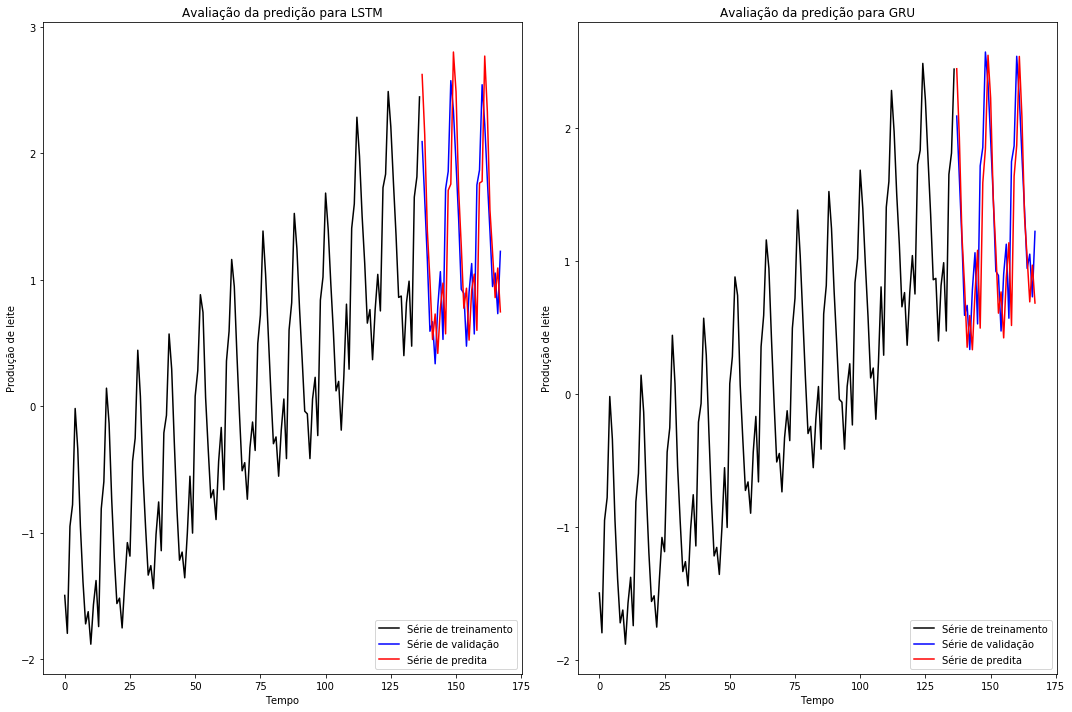

In [44]:
# Plots
fig, ax = plt.subplots(1,2, figsize=(15,10));
# LSTM
ax[0].plot(xtrain,yt, label='Série de treinamento', color='black')
ax[0].plot(xpreds,yv, label='Série de validação', color='blue')
ax[0].plot(xpreds,ypLSTM, label='Série de predita', color='red')  
ax[0].set_title('Avaliação da predição para LSTM')
ax[0].set_xlabel('Tempo')
ax[0].set_ylabel('Produção de leite')
ax[0].legend(loc='lower right')

# GRU
ax[1].plot(xtrain,yt, label='Série de treinamento', color='black')
ax[1].plot(xpreds,yv, label='Série de validação', color='blue')
ax[1].plot(xpreds,ypGRU, label='Série de predita', color='red')  
ax[1].set_title('Avaliação da predição para GRU')
ax[1].set_xlabel('Tempo')
ax[1].set_ylabel('Produção de leite')
ax[1].legend(loc='lower right')
# Default to improve spaces between the plots
plt.tight_layout()

In [45]:
# Avaliar métricas para LSTM
LSTM_metric = lstm_model.evaluate_generator(generator=producao_test_sequence)[1]
print('LSTM alcançou ', LSTM_metric,' de MSE.')

# Avaliar métrica para GRU
GRU_metric = gru_model.evaluate_generator(generator=producao_test_sequence)[1]
print('GRU alcançou ', GRU_metric,' de MSE.')

LSTM alcançou  0.24796736  de MSE.
GRU alcançou  0.21812865  de MSE.


# Parte 6: Preço

## Criação do modelo

In [46]:
# Criando objeto do modelo
ctf_model = Sequential(name='LEITE_MODEL_C_TF')

In [47]:
# Adicionar primeira camada
ctf_model.add(GRU(units=100, activation='relu', input_shape=(window_size, 1), return_sequences=True))
# Adicionar segunda camada
ctf_model.add(GRU(units=100, activation='relu'))
# Adicionar camada de saida
ctf_model.add(Dense(units=1))

# Descrição do modelo
ctf_model.summary()

Model: "LEITE_MODEL_C_TF"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 3, 100)            30900     
_________________________________________________________________
gru_3 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 91,601
Trainable params: 91,601
Non-trainable params: 0
_________________________________________________________________


## Aplicação da técnica de Transfer Learning

In [48]:
# Aplicando Transfer Learning
ctf_model.layers[0].set_weights(gru_model.layers[0].get_weights())
ctf_model.layers[1].set_weights(gru_model.layers[1].get_weights())
ctf_model.layers[2].set_weights(gru_model.layers[2].get_weights())

## Compilação e treinamento do modelo

In [63]:
# Compilar o modelo
ctf_model.compile(optimzer='adam', loss='mse', metrics=['mse'])
# Treinando o modelo
CTF_history = ctf_model.fit_generator(preco_train_sequence, epochs=15, verbose=2);

Epoch 1/20
36/36 - 1s - loss: 0.1047 - mse: 0.1050
Epoch 2/20
36/36 - 1s - loss: 0.0997 - mse: 0.1000
Epoch 3/20
36/36 - 1s - loss: 0.0934 - mse: 0.0936
Epoch 4/20
36/36 - 1s - loss: 0.0967 - mse: 0.0970
Epoch 5/20
36/36 - 1s - loss: 0.0971 - mse: 0.0973
Epoch 6/20
36/36 - 1s - loss: 0.0896 - mse: 0.0898
Epoch 7/20
36/36 - 1s - loss: 0.0943 - mse: 0.0946
Epoch 8/20
36/36 - 1s - loss: 0.0871 - mse: 0.0872
Epoch 9/20
36/36 - 1s - loss: 0.0974 - mse: 0.0976
Epoch 10/20
36/36 - 1s - loss: 0.0900 - mse: 0.0903
Epoch 11/20
36/36 - 2s - loss: 0.0954 - mse: 0.0957
Epoch 12/20
36/36 - 1s - loss: 0.1026 - mse: 0.1029
Epoch 13/20
36/36 - 1s - loss: 0.0876 - mse: 0.0874
Epoch 14/20
36/36 - 1s - loss: 0.0938 - mse: 0.0940
Epoch 15/20
36/36 - 1s - loss: 0.0971 - mse: 0.0974
Epoch 16/20
36/36 - 1s - loss: 0.0924 - mse: 0.0927
Epoch 17/20
36/36 - 1s - loss: 0.0903 - mse: 0.0904
Epoch 18/20
36/36 - 1s - loss: 0.0976 - mse: 0.0979
Epoch 19/20
36/36 - 2s - loss: 0.0938 - mse: 0.0940
Epoch 20/20
36/36 - 2

## Avaliação dos resultados

In [64]:
# Prever valores futuros(validação) com GRU para preços da Apple
CTF_pred = ctf_model.predict_generator(generator=preco_test_sequence)

In [65]:
# Criando o eixo X para fazer os plots de predição
xtrain = range(0, len(preco_train) + window_size)
xpreds = range(len(preco_train) + window_size, len(preco_train) + len(preco_test))

In [66]:
# Criando os eixos Y para série de treinamento, validação, predição de LSTM e GRU
yt = list(preco_train.reshape(-1)) + list(preco_test.reshape(-1)[0:window_size])
yv = list(preco_test.reshape(-1))[window_size:]
ypCTF = list(CTF_pred.reshape(-1))

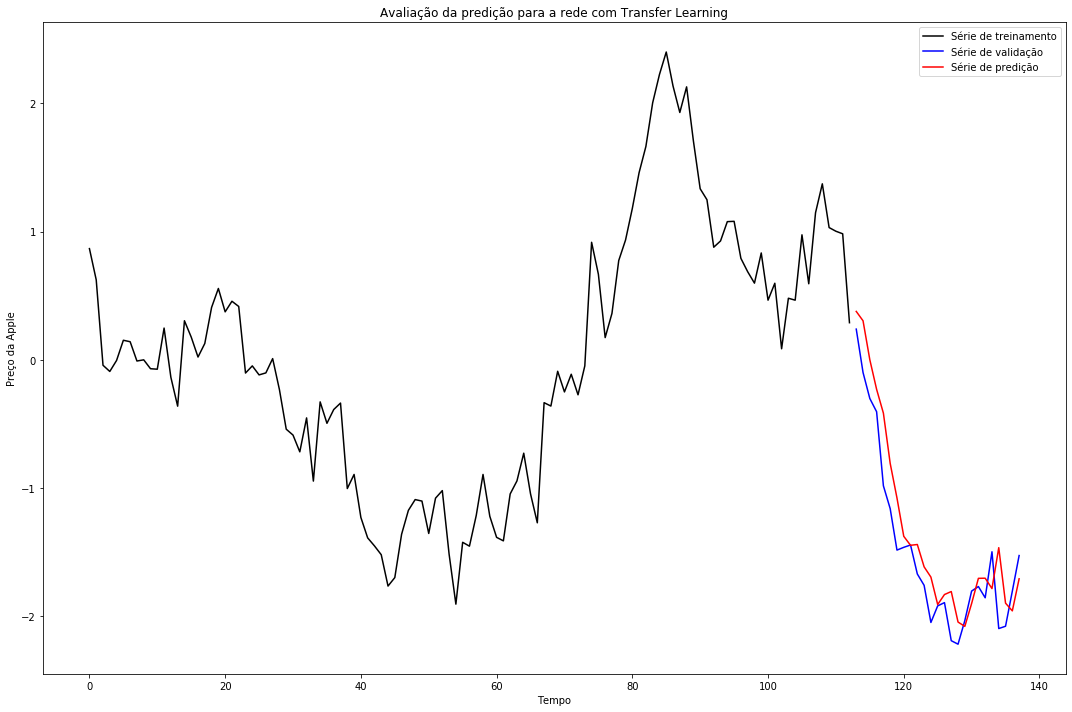

In [68]:
# Plots
fig = plt.figure(figsize=(15,10));
# CTF - Com Transfer Learning
plt.plot(xtrain,yt, label='Série de treinamento', color='black')
plt.plot(xpreds,yv, label='Série de validação', color='blue')
plt.plot(xpreds,ypCTF, label='Série de predição', color='red')  
plt.title('Avaliação da predição para a rede com Transfer Learning')
plt.xlabel('Tempo')
plt.ylabel('Preço da Apple')
plt.legend(loc='upper right')


# Default to improve spaces between the plots
plt.tight_layout()

# Conclusão

# Referências